# Time Series Imagery Data with Google Earth Engine

In [21]:
import geemap
import ee
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
from PIL import Image

Our workflow is as follows:  
1. Use Sentinel-2 imagery for the time interval (2015-2024)
2. Filter the datast to cover New York City's spatial bounds over the time range
3. Preprocess the imagery
   1. Cloud masking
   2. Extracting RGB bands, NIR for roofs
4. Export GEE imagery as GeoTIFFs or numpy arrays for SAM input

## Access time-series imagery

In [7]:
# authenticate if needed
ee.Authenticate()

# initialize the Earth Engine library
ee.Initialize(project='nyc-development')

# Define Brooklyn boundary
nyc = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.And(
    ee.Filter.inList('NAME',[
        'New York', 'Kings', 'Queens', 'Bronx', 'Richmond']),
    ee.Filter.eq('STATEFP', '36')
    )
)

# visualize NYC boundaries
Map = geemap.Map()
Map.centerObject(nyc, 11)
Map.addLayer(nyc, {'color': 'cornflowerblue'}, 'NYC Boroughs')
Map

Map(center=[40.66381799523255, -73.93856333744463], controls=(WidgetControl(options=['position', 'transparent_…

{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32618', 'crs_transform': [60, 0, 499980, 0, -60, 4500000]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32618', 'crs_transform': [20, 0, 499980, 0, -20, 4500000

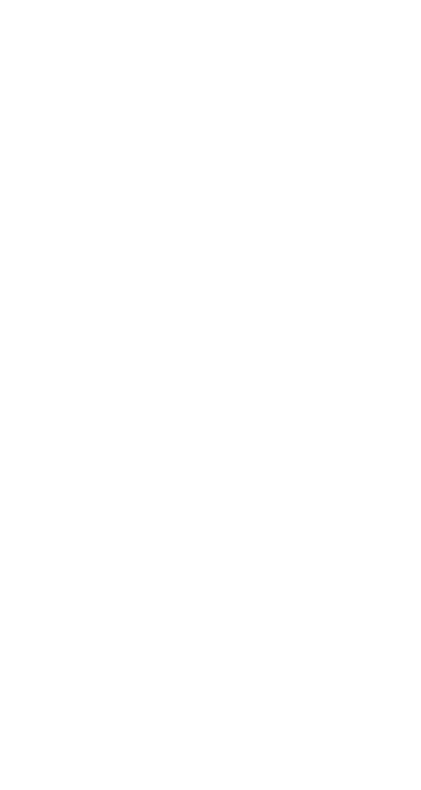

In [23]:
# define Sentinel-2 image collection
sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(nyc) \
    .filterDate('2023-06-01', '2023-06-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # filter by cloud cover

# convert the filtered collection into a Python list
image_list = sentinel2.toList(sentinel2.size())

# function to download and plot an image
def plot_ee_image(ee_image, region, vis_params, ax, scale=100):
    """download an earth engine image and plot it using matplotlib."""
    url = ee_image.clip(region).getThumbURL(
        {**vis_params, 'region': region.geometry().getInfo(), 'scale': scale}
    )
    
    # print url to see if the image request is successful
    print("image url:", url)
    
    # open the url and read the image
    with urllib.request.urlopen(url) as response:
        image = Image.open(response)
    
    # convert the image to a numpy array and plot
    ax.imshow(np.array(image))
    ax.axis('off')

# check the image metadata to see if it contains data
image_info = first_image.getInfo()
print(image_info)  # to see metadata about the image

# use a single borough (manhattan) as an example
manhattan = nyc.filter(ee.Filter.eq('NAME', 'New York'))

# visualization parameters for sentinel-2 rgb
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # rgb bands
    'min': 0,
    'max': 3000,  # adjusted range for sentinel-2 values
}

# plot the first image
fig, ax = plt.subplots(figsize=(10, 10))
plot_ee_image(first_image, manhattan, vis_params, ax, scale=500)  # scale adjusted
plt.show()

In [13]:
print(sentinel2.size().getInfo())  # Outputs the number of images in the filtered collection
image_list = sentinel2.toList(sentinel2.size())
print(image_list.getInfo())  # Lists metadata for the filtered images

6
[{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32618', 'crs_transform': [60, 0, 499980, 0, -60, 4500000]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32618', 'crs_transform': [20, 0, 499980, 0, -20, 4500

In [ ]:

# Load Landsat imagery (1980–2024)
landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").filterBounds(nyc)

# Preprocess and visualize
image = landsat.filterDate('2020-01-01', '2020-12-31').median()
Map = geemap.Map()
Map.centerObject(nyc)
Map.addLayer(image, {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000}, "Landsat")
Map


## Segment buildings

Next is to segment the buildings from the imagery with the SAM (Segment Anything) model:
1. Preprocess imagery to extract building-relevant features
2. Run SAM to segment buildings from each time-step image
3. Save segmentation masks as raster files or NetCDF format

In [ ]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the SAM model
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").cuda()
mask_generator = SamAutomaticMaskGenerator(sam)

# Load an image of Brooklyn
import cv2
image = cv2.imread("brooklyn_2020.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate segmentation masks
masks = mask_generator.generate(image_rgb)

# Save masks for further analysis
import numpy as np
np.save("segmentation_masks_2020.npy", masks)

## Utilize NetCDF for managing time-series data

We will combine the segmentation masks for each time step into a NetCDF file, and use xarray to handle the multi-dimensional data.

In [ ]:
import xarray as xr
import numpy as np

# Combine masks into a NetCDF structure
years = list(range(1980, 2025))
masks = [np.load(f"segmentation_masks_{year}.npy") for year in years]

ds = xr.Dataset(
    {"building_masks": (("time", "x", "y"), masks)},
    coords={"time": years, "x": range(masks[0].shape[0]), "y": range(masks[0].shape[1])}
)

ds.to_netcdf("brooklyn_building_growth.nc")

## Analyze and visualize results

We will calculate the number of buildings or total building area per year.  
We will also create plots to visualize the trends in building growth.

In [ ]:
import matplotlib.pyplot as plt

# Calculate total building area per year
building_area = ds.building_masks.sum(dim=["x", "y"])

# Plot trends
plt.figure(figsize=(10, 6))
plt.plot(ds.time, building_area, label="Total Building Area")
plt.xlabel("Year")
plt.ylabel("Building Area (pixels)")
plt.title("Urban Development in Brooklyn (1980–2024)")
plt.legend()
plt.show()